In [1]:
import math
import numpy as np
from time import time
import pandas as pd

"""
m is a resultant brightness
m$_{\odot}$ is a Sun’s magnitude
$\varphi$ is the satellite-sun-sensor solar phase angle (0º < STO < 90º)
A is the cross-sectonal area
$\textcolor{blue}{\rho}$ is the bond albedo
R$\textcolor{orange}{_{m}}$= is the range to target (400km < R$\textcolor{orange}{_m}$ < 2500 km) 
"""

mag_v_sun = -26.72              #Sun's V magnitude of Gaia   Jordi et al. 2010

In [15]:
def degtorad(x):
    x_rad = x*np.pi/180.
    return x_rad

In [20]:
print(degtorad(24.5))

print(x_rad(24.5))

0.4276056667386107
0.4276056667386107


In [21]:
def model_magnitud(mag_sun, phase_angle, cross_section, albedo, range_sat, mix_coe):

	degtorad = lambda x : x*np.pi/180.

	coe_1 = 2/(3*np.pi)
	coe_2 = 1/(4*np.pi)
	phase_angle_rad = degtorad(phase_angle)
	part1 = (coe_1 *((np.pi - phase_angle_rad)*np.cos(phase_angle_rad) - np.sin(phase_angle_rad))) - coe_2
	print(part1)
	mag = mag_sun - 2.5 * np.log10(cross_section * albedo * (mix_coe * part1) + coe_2) + 5*np.log10(range_sat)
	
	data = {'mag' : mag,
			'mag_sun' : mag_sun,
			'phase_angle' : phase_angle,
			'cross_sectio' : cross_section,
			'albedo' : albedo,
			'range_sat' : range_sat,
			'mix_coe' : mix_coe
	}
	
	return data

In [22]:

model_magnitud(-26.95, 24.5, 1, 0.5, 18423.2, 1)

0.3564921766929614


{'mag': -4.151481167672863,
 'mag_sun': -26.95,
 'phase_angle': 24.5,
 'cross_sectio': 1,
 'albedo': 0.5,
 'range_sat': 18423.2,
 'mix_coe': 1}

## Monte Carlo

In [136]:
np.random.seed(20000)
t0 = time()

-21.628069228198385

<AxesSubplot:ylabel='Count'>

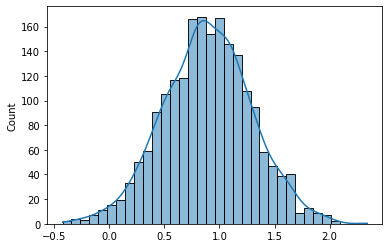

In [43]:
import math
import numpy as np
from numpy.random import normal
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

cross_section_0 = 0.9
albedo_0 = 0.5

cross_dist = normal(loc=0.9, scale=0.4, size=2000)
albedo = normal(loc=0.5, scale=0.25, size=2000)
sns.histplot(cross_dist, kde=True)

0.9238785631396729